In [1]:
import os
import sys
import pickle
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchsummary import summary
import models

from PIL import Image
import torchvision.utils as vutils
import matplotlib.pyplot as plt

import random
def manual_seed(seed):
    np.random.seed(seed) #1
    random.seed(seed) #2
    torch.manual_seed(seed) #3Q
    torch.cuda.manual_seed(seed) #4.1
    torch.cuda.manual_seed_all(seed) #4.2
    torch.backends.cudnn.benchmark = False #5 
    torch.backends.cudnn.deterministic = True #6
    


In [2]:
manual_seed(22)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 64 # 64

In [4]:
print(device)

cuda


In [5]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data',train=True, download=False, transform=train_transforms)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=False)

val_dataset = torchvision.datasets.FashionMNIST(root='./data',train=False, download=False, transform=train_transforms)
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)


In [6]:
EPOCHS = 101
# LR = 1e-4
LR = 5e-5
LATENT_DIM = 2

In [7]:
encoder = models.Encoder(LATENT_DIM)
decoder = models.Decoder(LATENT_DIM)
model = models.VAEMLP(encoder, decoder)
print(model)

VAEMLP(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (z_mean): Linear(in_features=500, out_features=2, bias=True)
    (z_logvar): Linear(in_features=500, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=500, out_features=784, bias=True)
    )
  )
)


In [8]:
def kl_function(mean, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return KLD
MSE_loss = nn.MSELoss(reduction='sum')
KL_loss = kl_function

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

0 EPOCH - MSE : 43.54923, KL : 4.50446, ALL : 48.05369
1 EPOCH - MSE : 29.55758, KL : 4.82541, ALL : 34.38298
2 EPOCH - MSE : 28.16010, KL : 4.75669, ALL : 32.91678
3 EPOCH - MSE : 27.42391, KL : 4.70374, ALL : 32.12765
4 EPOCH - MSE : 26.93762, KL : 4.68723, ALL : 31.62485
5 EPOCH - MSE : 26.53603, KL : 4.64277, ALL : 31.17880
6 EPOCH - MSE : 26.20813, KL : 4.64448, ALL : 30.85261
7 EPOCH - MSE : 25.94239, KL : 4.62535, ALL : 30.56774
8 EPOCH - MSE : 25.70366, KL : 4.62686, ALL : 30.33051
9 EPOCH - MSE : 25.49345, KL : 4.62406, ALL : 30.11751
10 EPOCH - MSE : 25.30914, KL : 4.62898, ALL : 29.93812
11 EPOCH - MSE : 25.13298, KL : 4.62585, ALL : 29.75883
12 EPOCH - MSE : 25.00188, KL : 4.64936, ALL : 29.65124
13 EPOCH - MSE : 24.85082, KL : 4.65267, ALL : 29.50349
14 EPOCH - MSE : 24.72673, KL : 4.66491, ALL : 29.39164
15 EPOCH - MSE : 24.61657, KL : 4.66655, ALL : 29.28311
16 EPOCH - MSE : 24.51156, KL : 4.68083, ALL : 29.19239
17 EPOCH - MSE : 24.40914, KL : 4.69736, ALL : 29.10649
18

/tmp/ipykernel_348863/221149490.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


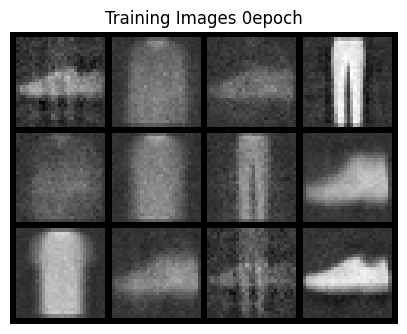

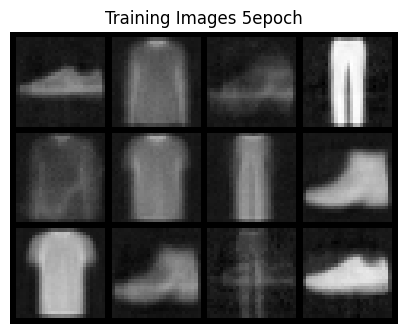

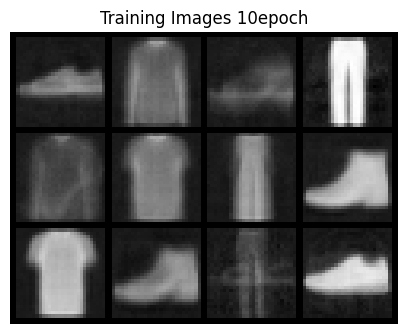

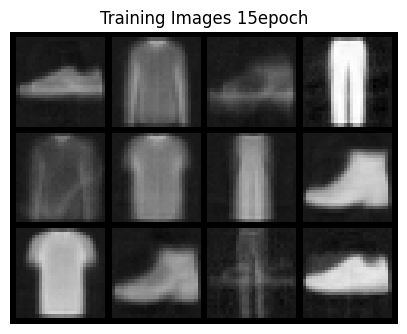

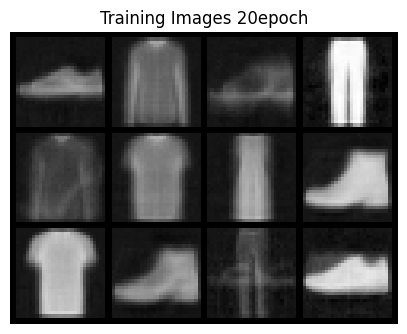

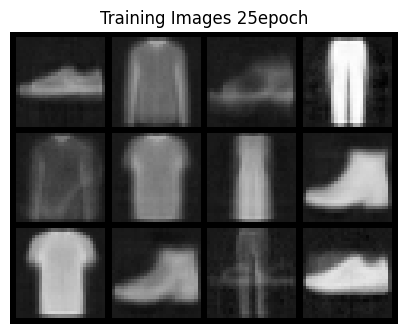

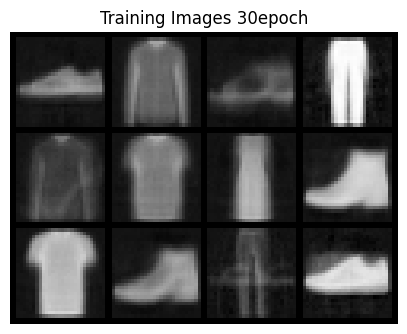

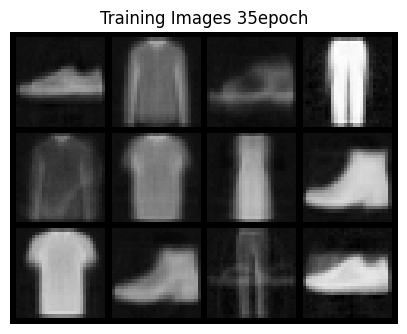

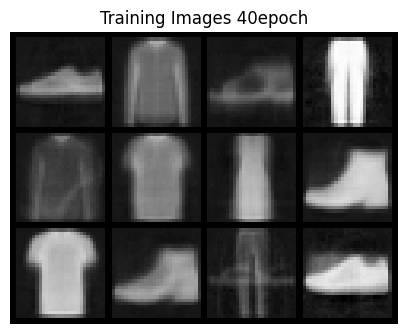

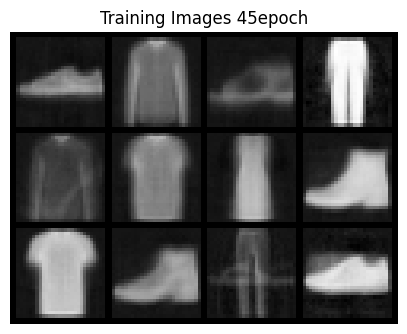

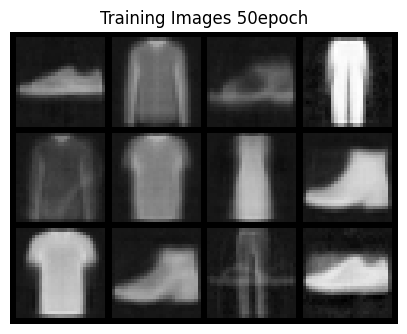

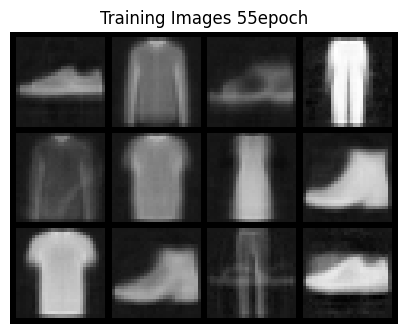

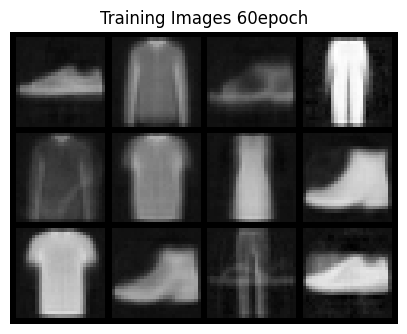

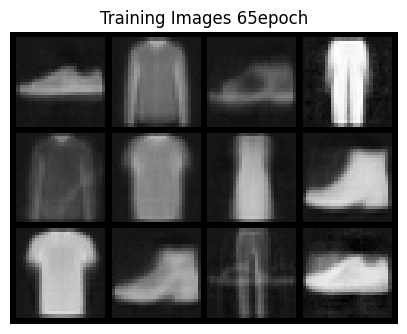

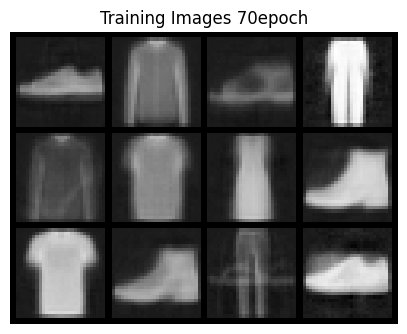

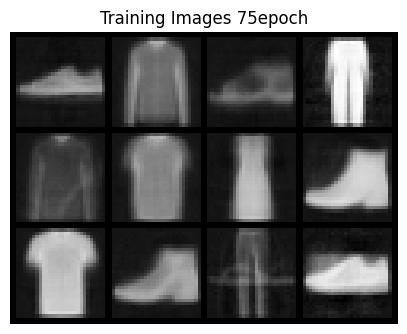

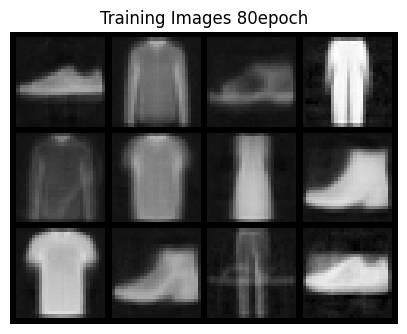

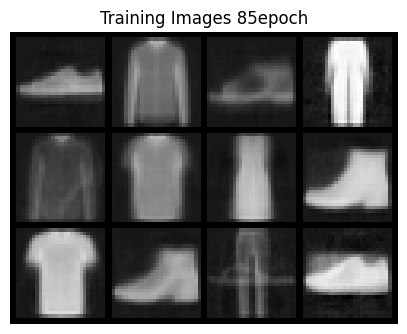

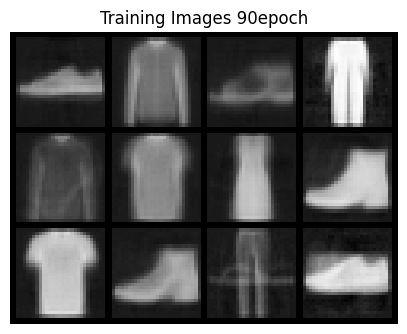

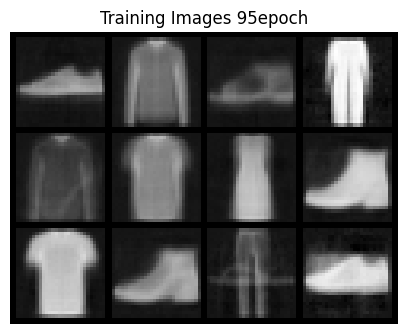

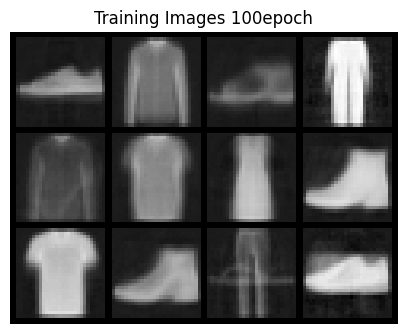

In [9]:
model.to(device)
generate_imgs = []
noise = torch.randn(batch_size, LATENT_DIM).to(device)
mse_list = []
kl_list = []
all_list = []

val_mse_list = []
val_kl_list = []
val_all_list = []
for epoch in range(EPOCHS):
    model.train()
    mse_loss = 0
    kl_loss = 0
    all_loss = 0
    for i, (imgs, _ ) in enumerate(train_loader):
        imgs = imgs.to(device)
        imgs = torch.flatten(imgs,1)
        optimizer.zero_grad()
        
        y , mean, log_var = model(imgs)
    
        mse = MSE_loss(y,imgs)
        kl = KL_loss(mean,log_var)
    
        loss = 1 * mse + 1 * kl
        loss.backward()
    
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        mse_loss += mse.item()    
        kl_loss += kl.item()    
        all_loss += loss.item() 
    
    mse_loss /=len(train_dataset.data)    
    kl_loss  /=len(train_dataset.data) 
    all_loss /=len(train_dataset.data) 
    
    print(f"{epoch} EPOCH - MSE : {mse_loss:.5f}, KL : {kl_loss:.5f}, ALL : {all_loss:.5f}")   
        
    mse_list.append(mse_loss)
    kl_list.append(kl_loss)
    all_list.append(all_loss)
    if (epoch % 5 == 0):
        with torch.no_grad():
            model.eval()
            
            fake = model.decoder(noise[:12]).detach().cpu().view(12,1,28,28)
            # std = torch.exp(log_var / 2)
            # latent = mean + std * noise
            # fake = model.decoder(latent[:12]).detach().cpu().view(-1, 1, 28, 28)
            generate_imgs.append(vutils.make_grid(fake, nrow=4, padding=2,normalize=True))
            plt.figure(figsize=(5,5))
            plt.axis("off")
            plt.title(f"Training Images {epoch}epoch")
            plt.imshow(np.transpose(generate_imgs[-1],(1,2,0)))
            plt.savefig(f'./gen_imgs/{epoch}.png')


101


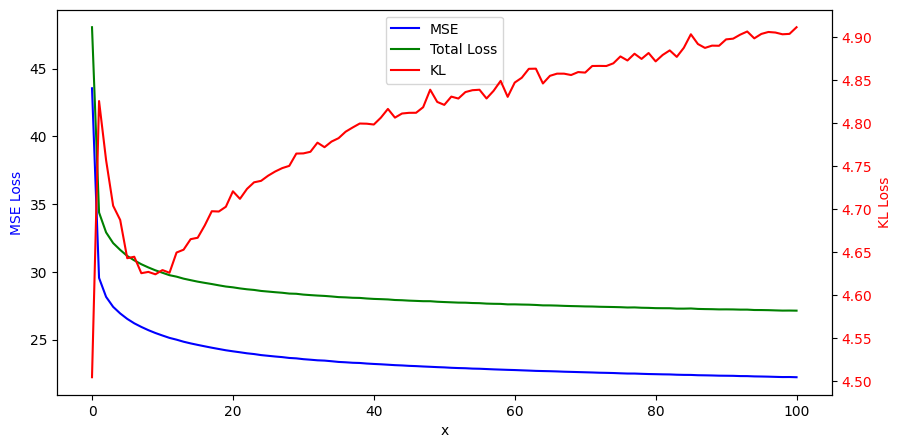

In [10]:
import matplotlib.pyplot as plt
print(len(mse_list))
fig = plt.figure(figsize=(10,5))
# plt.title(f"VAE Training Loss")
# plt.plot(mse_list,label="MSE")
# plt.plot(kl_list,label="KL")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")

ax1 = fig.add_subplot() ## 
color1 = 'b'
ax1.plot(mse_list, color=color1, label='MSE')
ax1.plot(all_list, color='g', label='Total Loss')
ax1.set_xlabel('x')
ax1.set_ylabel('MSE Loss', color=color1)

color2 = 'r'
ax2 = ax1.twinx()
ax2.plot(kl_list, color=color2, label = "KL")
ax2.set_ylabel('KL Loss', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.show()

torch.Size([3, 92, 122])


/tmp/ipykernel_348863/3667863127.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


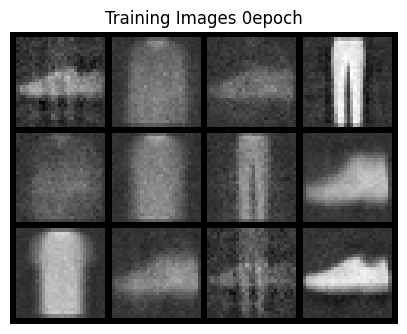

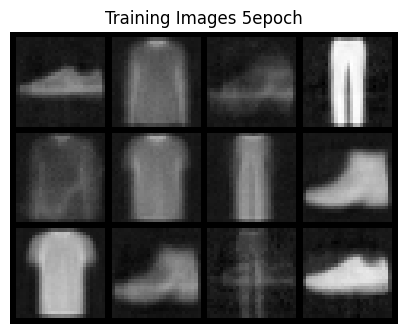

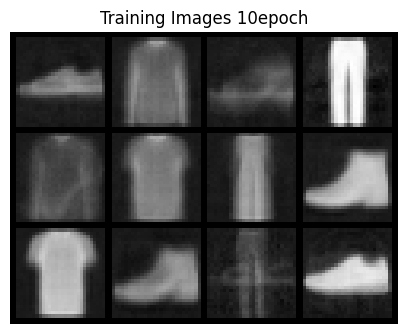

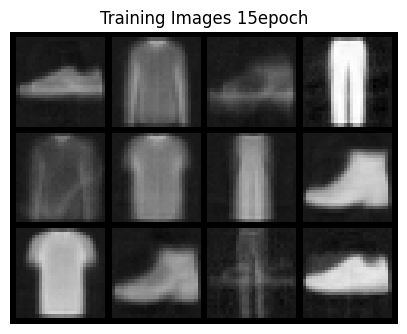

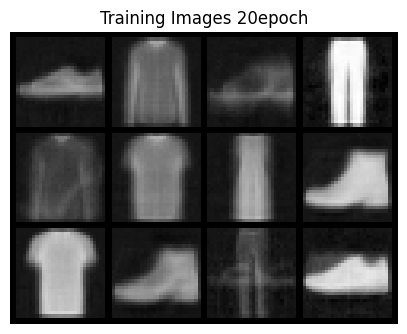

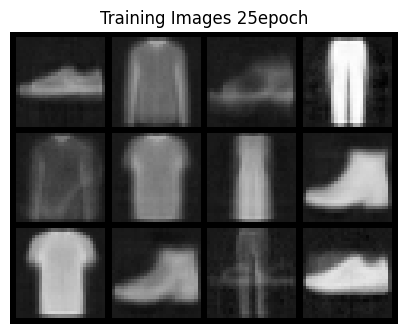

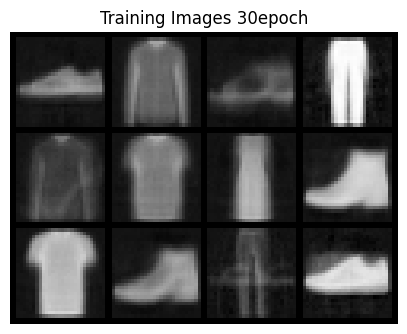

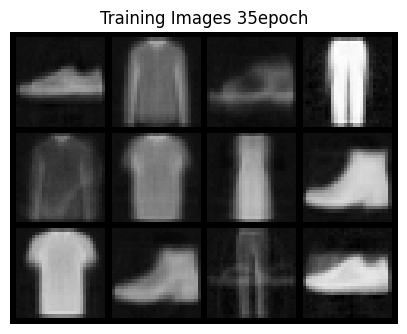

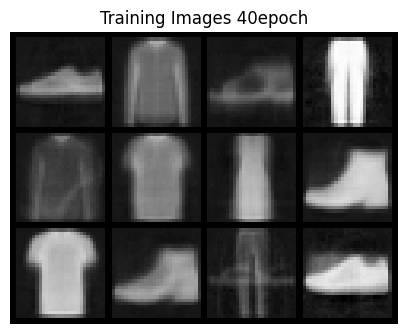

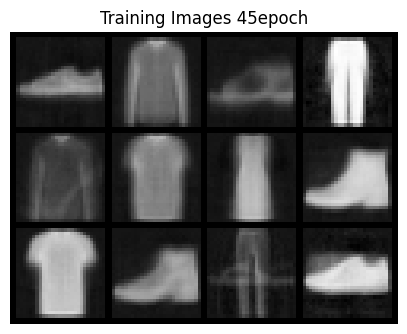

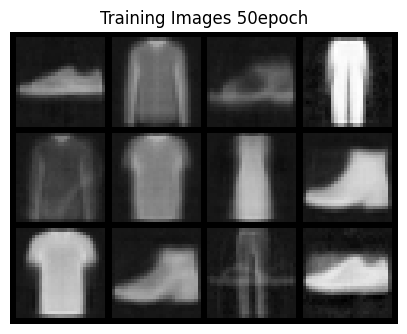

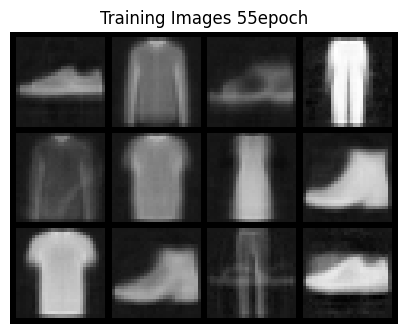

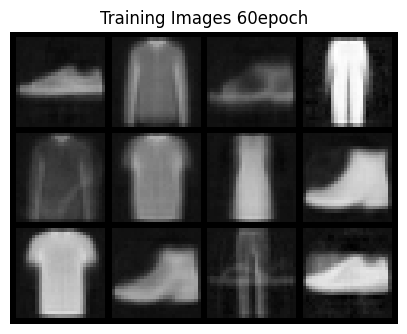

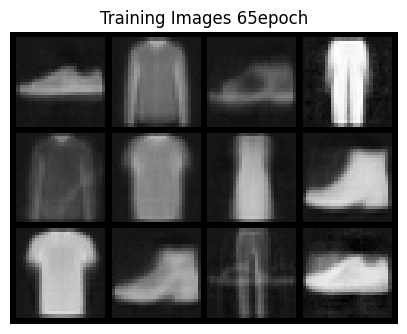

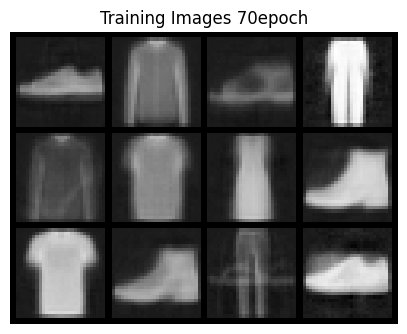

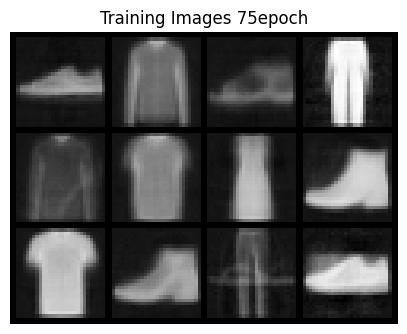

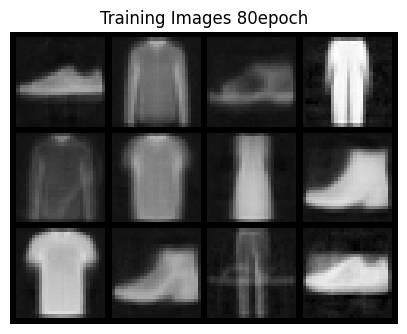

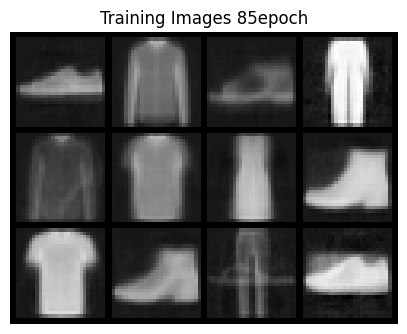

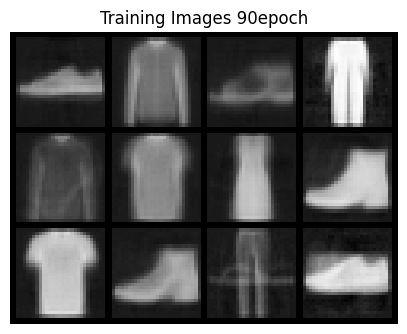

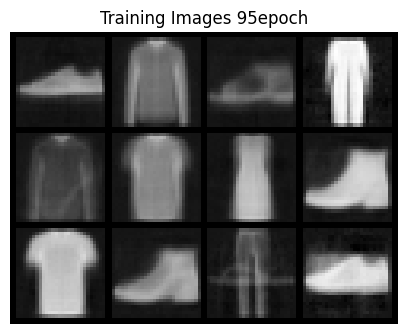

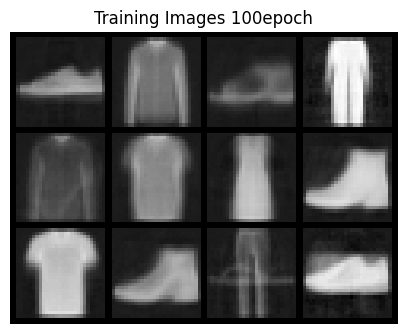

In [11]:
list_num = len(generate_imgs)
print(generate_imgs[0].shape)
for i in range(0,list_num,1):
    plt.figure(figsize=(5,5))
    target_i = i*5
    plt.axis("off")
    plt.title(f"Training Images {target_i}epoch")
    plt.imshow(np.transpose(generate_imgs[i],(1,2,0)))
